#### Imports


In [81]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import random
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

#### Functions

In [5]:
def read_data(file_name):
    data = pd.read_csv(file_name)
    feature_cols = []
    for label in data.columns:
        if label[0] == "X" or label[0] == "Y":
            feature_cols.append(label)
        elif label[0] == "R":
            break
    

    label_cols = ["ResultPositionX", "ResultPositionY"]
    x = data[feature_cols]
    y = data[label_cols]
    return x, y

In [293]:
def adjust_x_y(x, y):
    x_to_y_index = 0
    width = 2*3.7/64
    for i in range(len(x.columns)):
        if x.columns[i][0] == 'Y':
            x_to_y_index = i 
            break

    # min_x_strip_ID = x.iloc[:, 0:x_to_y_index].min().min()
    # min_y_strip_ID= x.iloc[:, x_to_y_index:(len(x.columns) // 2)].min().min()

    y['ResultPositionX'] = (y['ResultPositionX'] + 3.7) - x['XStripID1'] * width
    y['ResultPositionY'] = (y['ResultPositionY'] + 3.7) - x['YStripID1'] * width

    adj_x = x.copy()
    cols = list(adj_x.columns[:len(x.columns) // 2])
    adj_x = adj_x.drop(cols, axis=1)

    # adj_y = y.copy()
    adj_y = pd.DataFrame()
    adj_y["ResultDistance"] = (y["ResultPositionX"]**2 + y["ResultPositionY"]**2)**(1/2)
    adj_y["ResultDirection"] = np.degrees(np.atan(y["ResultPositionY"], y["ResultPositionX"]))
    

    return adj_x, adj_y


In [ ]:
def train_model_normal(x_train, y_train, n_estimators=12, random_state=12345, verbose = 1):
    rf = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=20,
        min_samples_leaf=2,
        min_samples_split=4,
        max_features='sqrt',
        random_state=random_state, 
        verbose=verbose
    )
    rf.fit(
        x_train, y_train
    )
    return rf


In [292]:
def test(rf, x_test, y_test):
    y_pred = rf.predict(x_test)
    distance = []
    direction = []
    
    for i in range(len(y_test)):
        mag_true, dir_true, mag_pred, dir_pred = y_test.iloc[i].iloc[0], y_test.iloc[i].iloc[0], y_pred[i][0], y_pred[i][0]
        x_t = mag_true * np.cos(dir_true)
        y_t = mag_true * np.sin(dir_true)
        x_p = mag_pred * np.cos(dir_pred)
        y_p = mag_pred * np.sin(dir_pred)

        # error_x = y_test.iloc[i].iloc[0] - y_pred[i][0]
        # error_y = y_test.iloc[i].iloc[1] - y_pred[i][1]
        # distance.append(math.sqrt(error_x ** 2 + error_y**2))
        
        e_x = x_t - x_p
        e_y = y_t - y_p
        distance.append(math.sqrt(e_x**2 + e_y**2))

        direction.append(abs(y_pred[i][1] - y_test.iloc[i].iloc[1]))
        

    return distance, direction

In [ ]:
def test_old(rf, x_test, y_test): # OLD CODE - not being used
    y_pred = rf.predict(x_test)
    distance = []
    direction = []
    
    for i in range(len(y_test)):
        error_x = y_test.iloc[i].iloc[0] - y_pred[i][0]
        error_y = y_test.iloc[i].iloc[1] - y_pred[i][1]
        distance.append(math.sqrt(error_x ** 2 + error_y**2))

        # dp = y_test.iloc[i].iloc[2]  * y_pred[i][2] + y_test.iloc[i].iloc[3]  * y_pred[i][3]
        # mag1 = math.sqrt(y_test.iloc[i].iloc[2] ** 2 + y_test.iloc[i].iloc[3] ** 2)
        # mag2 = math.sqrt(y_pred[i][2] ** 2 + y_pred[i][3] ** 2)
        # direction.append(math.degrees(math.acos(dp / mag1 / mag2)))

        pred = np.array([y_pred[i][0], y_pred[i][1]])
        real = np.array([y_test.iloc[i].iloc[0], y_test.iloc[i].iloc[1]])
        cos_angle = np.dot(pred, real) / (np.linalg.norm(pred) * np.linalg.norm(real))
        direction.append(math.degrees(math.acos(np.clip(cos_angle, -1.0, 1.0))))
        # direction.append(math.degrees(np.atan(pred) - np.atan(real)))

    return distance, direction

In [ ]:
def train_number_of_trees(x_train, x_test, y_train, y_test, verbose=1):
    train_loss_dir = []
    test_loss_dir = []
    train_loss_dis = []
    test_loss_dis = []
    n_trees = np.linspace(10, 400, 10, dtype=int)

    rf = RandomForestRegressor(n_estimators=10, random_state=12345, warm_start=True, verbose=verbose)
    for n in n_trees:
        print(f"Running RandomForestRegressor on {n} trees")
        rf.n_estimators = n  # Increase number of trees
        rf.fit(x_train, y_train)  # Train the model incrementally

        distance_test, direction_test = test(rf, x_test, y_test)
        distance_train, direction_train = test(rf, x_train, y_train)
        
        test_loss_dir.append(np.average(direction_test))
        test_loss_dis.append(np.average(distance_test))
        train_loss_dir.append(np.average(direction_train))
        train_loss_dis.append(np.average(distance_train))
    
    plt.figure(figsize=(8, 5))
    plt.plot(n_trees, train_loss_dis, label="Training Distance MSE", marker="o")
    plt.plot(n_trees, test_loss_dis, label="Test Distance MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Distance Mean Squared Error (cm)")
    plt.title("Training and Test Loss Based on Number of Trees")
    plt.legend()


    plt.figure(figsize=(8, 5))
    plt.plot(n_trees, train_loss_dir, label="Training Direction MSE", marker="o")
    plt.plot(n_trees, test_loss_dir, label="Test Direction MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Direction Mean Squared Error (degrees)")
    plt.title("Training and Test Loss Based on Number of Trees")
    plt.legend()

    plt.show()

    return rf


In [71]:
def train_depth(x_train, x_test, y_train, y_test, verbose = 1):
    train_loss_dir = []
    test_loss_dir = []
    train_loss_dis = []
    test_loss_dis = []
    depths = list(range(10, 51, 5))

    
    for depth in depths:
        print(f"Running RandomForestRegressor with depth {depth}")
        rf = RandomForestRegressor(n_estimators=100, random_state=12345, max_depth = depth, verbose=verbose)
        rf.fit(x_train, y_train)  # Train the model incrementally
        
        # Predict on training and test data
        distance_test, direction_test = test(rf, x_test, y_test)
        distance_train, direction_train = test(rf, x_train, y_train)
        
        # Store the errors
        test_loss_dir.append(np.average(direction_test))
        test_loss_dis.append(np.average(distance_test))
        train_loss_dir.append(np.average(direction_train))
        train_loss_dis.append(np.average(distance_train))

    plt.figure(figsize=(8, 5))
    plt.plot(depths, train_loss_dis, label="Training Distance MSE", marker="o")
    plt.plot(depths, test_loss_dis, label="Test Distance MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Distance Mean Squared Error (cm)")
    plt.title("Training and Test Loss Based on Depth of Trees")
    plt.legend()

    plt.figure(figsize=(8, 5))
    plt.plot(depths, train_loss_dir, label="Training Direction MSE", marker="o")
    plt.plot(depths, test_loss_dir, label="Test Direction MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Direction Mean Squared Error (degrees)")
    plt.title("Training and Test Loss Based on Depth of Trees")
    plt.legend()

    plt.show()

    return rf

#### Run the Model (Call Functions)

In [300]:
# set up model
data = "output_x2_y2.csv"
print("Reading Data...")
x, y = read_data(data)
print("Adjusting Data...")
x, y = adjust_x_y(x, y)
print("Split Data...")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 12345)
print("Done")

y

Reading Data...
Adjusting Data...
Split Data...
Done


,ResultDistance,ResultDirection
0,0.149779,0.874266
1,0.091197,3.341992
2,0.205485,8.616480
3,0.113182,3.934322
4,0.133804,4.552856
...,...,...
52380,0.170169,1.736962
52381,0.045011,2.555129
52382,0.212330,5.952153
52383,0.168563,3.374253


In [301]:
# run the model - normal
print("Training model...")
rf = train_model_normal(x_train, y_train, verbose = 1)
print("Validating model...")
distance, direction = test(rf, x_test, y_test)
print("Done")

Training model...
Validating model...
Done


Training model...
Running RandomForestRegressor on 10 trees
Running RandomForestRegressor on 53 trees
Running RandomForestRegressor on 96 trees
Running RandomForestRegressor on 140 trees
Running RandomForestRegressor on 183 trees
Running RandomForestRegressor on 226 trees
Running RandomForestRegressor on 270 trees
Running RandomForestRegressor on 313 trees
Running RandomForestRegressor on 356 trees
Running RandomForestRegressor on 400 trees


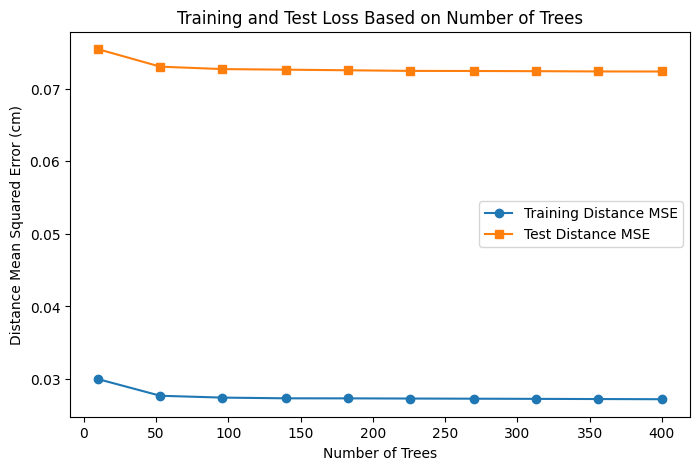

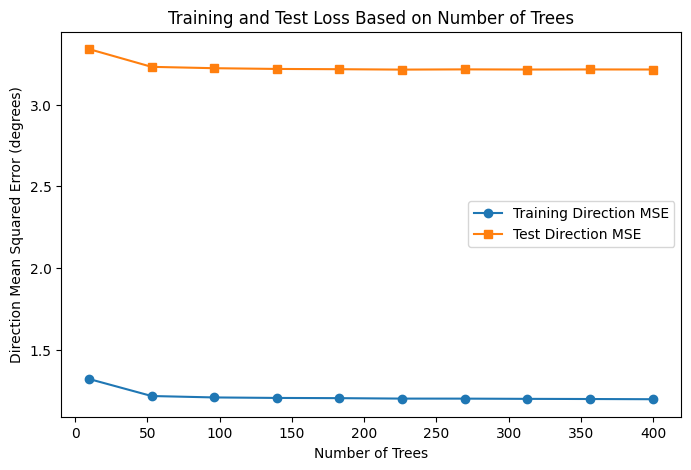

Validating model...
Done


In [299]:
#actually run the model - see effect of # of trees
print("Training model...")
rf = train_number_of_trees(x_train, x_test, y_train, y_test, verbose = 0)
print("Validating model...")
distance, direction = test(rf, x_test, y_test)
print("Done")

Training model...
Running RandomForestRegressor with depth 10
Running RandomForestRegressor with depth 15
Running RandomForestRegressor with depth 20
Running RandomForestRegressor with depth 25
Running RandomForestRegressor with depth 30
Running RandomForestRegressor with depth 35
Running RandomForestRegressor with depth 40
Running RandomForestRegressor with depth 45
Running RandomForestRegressor with depth 50


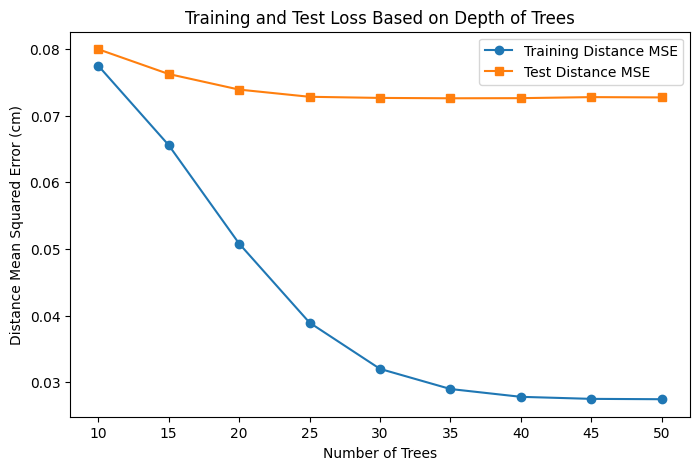

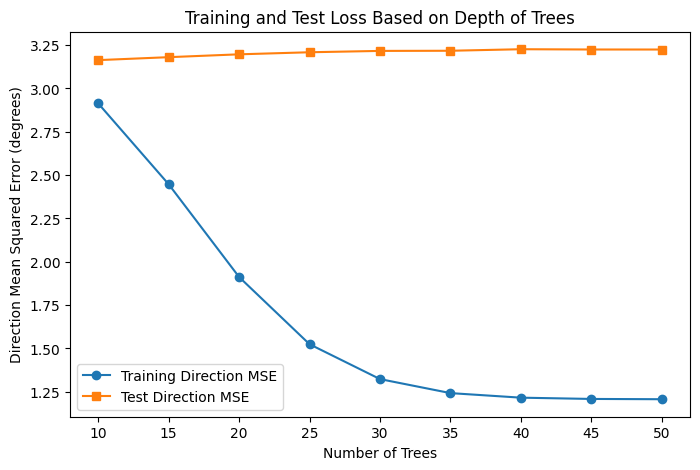

Validating model...
Done


In [298]:
# run the model - see effect of # of tree splits
print("Training model...")
rf = train_depth(x_train, x_test, y_train, y_test, verbose = 0)
print("Validating model...")
distance, direction = test(rf, x_test, y_test)
print("Done")

#### Plots + Results

Average distance: 0.049341183713647555


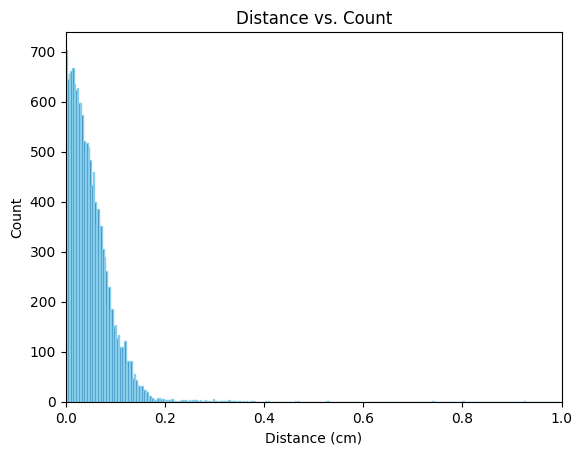

In [302]:
# Plots Distance vs Count

print("Average distance:", np.average(distance))
plt.hist(distance, bins=500, edgecolor='skyblue')
bottom, top = plt.ylim()
# plt.ylim(0, 10)
plt.xlim(0, 1)
plt.xlabel('Distance (cm)')
plt.ylabel('Count')
plt.title('Distance vs. Count')
plt.show()

Average direction: 2.8927755605902865
Standard devation: 2.408275484991007


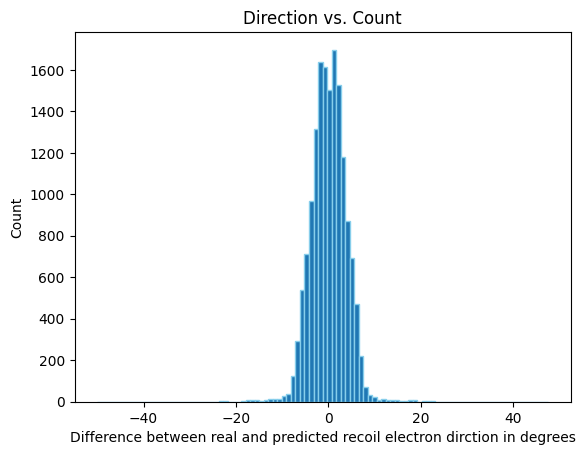

In [303]:
# Plots Direction vs Count

print("Average direction:", np.average(direction))
print("Standard devation:", np.std(direction))
for i in range(len(direction)):
    direction[i] *= random.choice([1, -1])
    
plt.hist(direction, bins=100, edgecolor='skyblue')
plt.xlabel('Difference between real and predicted recoil electron dirction in degrees')
plt.ylabel('Count')
plt.title('Direction vs. Count')
plt.show()